In [38]:
import tensorflow as tf
import shutil
import csv
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [69]:
def make_kaggle_submission_file(predictions, modelName):
    ofile  = open('Kaggle_submision_{0}.csv'.format(modelName), "wb")
    writer = csv.writer(ofile)
    writer.writerow(["Id","EpiOrStroma"])
    for i,score in enumerate(predictions):
        writer.writerow([i,score])

    ofile.close()

In [39]:
def make_input_Tensorflow(data,dataset):
    ofile  = open('tensoflow_{0}.data'.format(dataset), "wb")
    writer = csv.writer(ofile)
    #writer.writerow(data_x_train.columns)
    for tupple in data.itertuples():
        row = []
        for ele in tupple[1:]:
            row.append(ele)
        writer.writerow(row)

    ofile.close()

In [40]:
def build_model_columns():
    continues_columns = []
    for column in _CSV_COLUMNS[:-1]:
        continues_columns.append(tf.feature_column.numeric_column(column))
    return continues_columns

In [41]:
def build_estimator(model_dir):
    """Build an estimator appropriate for the given model type."""
    columns = build_model_columns()
    
    return tf.estimator.LinearClassifier(
            model_dir=model_dir,
            feature_columns=columns,
            optimizer=tf.train.FtrlOptimizer(
            learning_rate=0.001,
            l1_regularization_strength=0.01,
            l2_regularization_strength=0.1))

In [42]:
def input_fn(data_file, num_epochs, shuffle, batch_size):
    """Generate an input function for the Estimator."""
    assert tf.gfile.Exists(data_file), (
        '%s not found. Please make sure you have either run data_download.py or '
        'set both arguments --train_data and --test_data.' % data_file)

    def parse_csv(value):
        print('Parsing', data_file)
        columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
        features = dict(zip(_CSV_COLUMNS, columns))
        labels = features.pop('label')
        return features, tf.equal(labels, 2)

    # Extract lines from input files using the Dataset API.
    dataset = tf.data.TextLineDataset(data_file)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

    dataset = dataset.map(parse_csv, num_parallel_calls=5)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

In [47]:
data_x_train = pd.read_csv("./X_train.csv")
X_test = pd.read_csv("./X_test.csv")
data_y_train = pd.read_csv("./y_train.csv")

_CSV_COLUMN_DEFAULTS = [[0.0] for _ in range(len(data_x_train.columns))]
_CSV_COLUMN_DEFAULTS.append([1.])
_CSV_COLUMNS = [str(col) for col in data_x_train.columns]
_CSV_COLUMNS.append('label')

X_train, X_val, Y_train, Y_val = train_test_split(data_x_train, data_y_train, test_size = 0.2, random_state = 0)

XY_train = pd.concat([X_train,Y_train['EpiOrStroma']], axis=1) 
XY_val = pd.concat([X_val,Y_val['EpiOrStroma']], axis=1) 
X_test['label'] = 0. 


sc_X = StandardScaler()
XY_train_scaled = pd.DataFrame(sc_X.fit_transform(XY_train), columns = _CSV_COLUMNS)
XY_train_scaled.loc[XY_train_scaled['label']>0,'label'] = 2
XY_train_scaled.loc[XY_train_scaled['label']<0,'label'] = 1

X_test_scaled = pd.DataFrame(sc_X.transform(X_test), columns = _CSV_COLUMNS)
#del X_test_scaled['label']


XY_val_scaled = pd.DataFrame(sc_X.transform(XY_val), columns = _CSV_COLUMNS)
XY_val_scaled.loc[XY_val_scaled['label']>0,'label'] = 2
XY_val_scaled.loc[XY_val_scaled['label']<0,'label'] = 1

_NUM_EXAMPLES = {'train': len(XY_train_scaled), 'validation': len(XY_val_scaled)}

In [48]:
make_input_Tensorflow(XY_train_scaled,"training")
make_input_Tensorflow(XY_val_scaled,"validation")
make_input_Tensorflow(X_test_scaled,"test")

In [8]:
model_dir = "./model/"
train_data  = "./tensoflow_training.data"
val_data = "./tensoflow_validation.data"
test_data = "./tensoflow_test.data"
train_epochs = 100
epochs_per_eval = 5
batch_size = 60
accuracies = []
errors = []
shutil.rmtree(model_dir, ignore_errors=True)
model = build_estimator(model_dir)

# Train and evaluate the model every `FLAGS.epochs_per_eval` epochs.
for n in range(train_epochs // epochs_per_eval):
    model.train(input_fn=lambda: input_fn(train_data, epochs_per_eval, True, batch_size))

    results = model.evaluate(input_fn=lambda: input_fn(val_data, 1, False, batch_size))

    # Display evaluation metrics
    print('Results at epoch', (n + 1) * epochs_per_eval)
    print('-' * 60)

    for key in sorted(results):
        if key=="accuracy":
            accuracies.append(results[key])
        if key=="average_loss":
            errors.append(results[key])
        print('%s: %s' % (key, results[key]))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa57a951650>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './model/', '_save_summary_steps': 100}
('Parsing', './tensoflow_training.data')
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./model/model.ckpt.
INFO:tensorflow:loss = 41.588837, step = 1
INFO:tensorflow:Saving checkpoints for 40 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 33.59446.
('Parsing', './tensoflow_validation.data')
INFO:tensorflow:Starting evaluation at 2018-02-17-00:54:45
INFO:tensorflow:Res

('Results at epoch', 35)
------------------------------------------------------------
accuracy: 0.81666666
accuracy_baseline: 0.64166665
auc: 0.885231
auc_precision_recall: 0.8731557
average_loss: 0.47524077
global_step: 280
label/mean: 0.64166665
loss: 28.514446
prediction/mean: 0.5111071
('Parsing', './tensoflow_training.data')
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-280
INFO:tensorflow:Saving checkpoints for 281 into ./model/model.ckpt.
INFO:tensorflow:loss = 22.160854, step = 281
INFO:tensorflow:Saving checkpoints for 320 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 29.06068.
('Parsing', './tensoflow_validation.data')
INFO:tensorflow:Starting evaluation at 2018-02-17-00:56:23
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-320
INFO:tensorflow:Finished evaluation at 2018-02-17-00:56:24
INFO:tensorflow:Saving dict for global step 320: accuracy = 0.81666666, accuracy_baseline = 0.64166665, a

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-560
INFO:tensorflow:Saving checkpoints for 561 into ./model/model.ckpt.
INFO:tensorflow:loss = 24.328339, step = 561
INFO:tensorflow:Saving checkpoints for 600 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 28.565426.
('Parsing', './tensoflow_validation.data')
INFO:tensorflow:Starting evaluation at 2018-02-17-00:58:01
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-600
INFO:tensorflow:Finished evaluation at 2018-02-17-00:58:03
INFO:tensorflow:Saving dict for global step 600: accuracy = 0.8333333, accuracy_baseline = 0.64166665, auc = 0.8938387, auc_precision_recall = 0.8811499, average_loss = 0.44278654, global_step = 600, label/mean = 0.64166665, loss = 26.567192, prediction/mean = 0.5184814
('Results at epoch', 75)
------------------------------------------------------------
accuracy: 0.8333333
accuracy_baseline: 0.64166665
auc: 0.8938387
auc_precision_

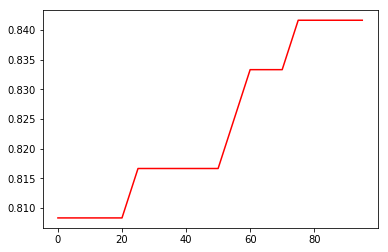

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([x for x in range(0,100,5)], accuracies, 'r')
plt.show()

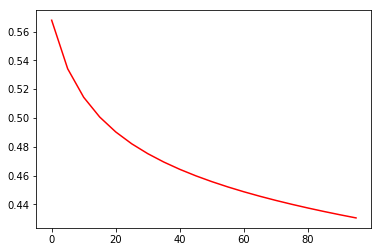

In [10]:
plt.plot([x for x in range(0,100,5)], errors, 'r')
plt.show()

In [72]:
test_data = "./tensoflow_test.data"
pred = model.predict(input_fn=lambda: input_fn(test_data, 1, False, 1))
make_kaggle_submission_file([int(x['classes'][0])+1 for x in pred],"tensorflow_LR")

('Parsing', './tensoflow_test.data')
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-800
